In [112]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,7.5)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

mpl.rc('font', **font)
import pandas as pd

In [2]:
from Rejection import Rejection
from Acceptance import Acceptance

In [188]:
from Particle import Particle
from Trimer import Trimer
from Edge import Edge
from Vertex import Vertex
from Writer import Writer
from TrimerGenerator import TrimerGenerator
from TrimerTemplate import TrimerTemplate
from Timestep import Timestep
import random
import hashlib
import numpy as np




options = {
    "clash_tolerance_top_top":150, # top points closer than this value will clash with each other (excluding closely connected neighbors)
    "clash_tolerance_top_vertex":70, # top points closer than this value to another vertex will clash (excluding closely connected neighbors)
    "clash_tolerance_vertex":60, # two vertex points closer than this value (and greater than the merge tolerance) will clash
    "merge_tolerance_beta":4, # vertex points closer a cutoff value will trigger a merge. The value is chosen from a gamma distribution with this beta value
    "edge_length_beta":5, # Trying to add a template to an adding edge that is outside of a tolerance will fail. That tolerance can be adjusted here, another gamma distribution
    "centroid_update_interval":200 # the number of timesteps between recalculating the particle centroid (used to determine the curvature direction)
}



# manually give the coordinates of a seed trimer, and initialize a particle object
def seed(trimer_generator,options):
    seed_vertex1 = Vertex(np.array([198.829, 170.530, 360.401]))
    seed_vertex2 = Vertex(np.array([161.790, 244.135, 376.374]))
    seed_vertex3 = Vertex(np.array([124.752, 199.392, 315.765]))
    seed_edge1 = Edge([seed_vertex1,seed_vertex2])
    seed_edge2 = Edge([seed_vertex2,seed_vertex3])
    seed_edge3 = Edge([seed_vertex3,seed_vertex1])
    seed_trimer = Trimer([seed_edge1,seed_edge2,seed_edge3])
    seed_center = np.array([231.149 , 245.5, 262.1035])
    particle = Particle(seed_trimer,trimer_generator=trimer_generator,options=options)
    particle.centroid = seed_center
    return particle



# define trimer add types
type1 = TrimerTemplate(angle_degrees=171,stem_length=71,adding_edge_length=91,template_type=1,weight=1)
type2 = TrimerTemplate(angle_degrees=149,stem_length=77,adding_edge_length=84,template_type=2,weight=1)
type3 = TrimerTemplate(angle_degrees=149,stem_length=77,adding_edge_length=84,template_type=3,weight=1)
type4 = TrimerTemplate(angle_degrees=171,stem_length=79,adding_edge_length=91,template_type=4,weight=3)
type5 = TrimerTemplate(angle_degrees=148,stem_length=77,adding_edge_length=84.5,template_type=5,weight=1)
type6 = TrimerTemplate(angle_degrees=148,stem_length=77,adding_edge_length=84.5,template_type=6,weight=1)
type7 = TrimerTemplate(angle_degrees=180,stem_length=77,adding_edge_length=88,template_type=7,weight=3) #flat hexamer

# collect the types we want to use together in an object
trimer_generator = TrimerGenerator([type1,type2,type3,type4,type5,type6,type7],options)

# execute the seed function (above) to get a particle object
particle = seed(trimer_generator,options)


## simulation
prob_max = 1500 # the range in which to select random numbers to decide add/remove. If the prob_on==prob_max, every step will try to add
prob_on = 1000 # the probability
on_off_ratio_remove_single = 1 / 0.6
on_off_ratio_remove_double = 1 / 0.01
prob_off_single = prob_on * (1 / on_off_ratio_remove_single)
prob_off_double = prob_on * (1 / on_off_ratio_remove_double)

print("Prob on:",prob_on)
print("Prob of single bonded trimer removal:",prob_off_single)
print("Prob of double bonded trimer removal:",prob_off_double)
print("All probs out of ",prob_max)



def simulate(particle,steps):
    print("Running ",steps," timesteps")
    rands_on = np.random.randint(0,prob_max,steps)
    rands_off = np.random.randint(0,prob_max,steps)

    complete_flag = False
    for i,rand_on in enumerate(rands_on):

        if particle.complete is False:
            tried_to_add = False
            tried_to_remove_single = False
            tried_to_remove_double = False
            add_outcome = None
            remove_single_outcome = None
            remove_double_outcome = None

            if (rand_on <= prob_on):
                add_outcome = particle.add()
                tried_to_add = True

            if (rands_off[i] <= prob_off_single):
                tried_to_remove_single = True
                if (len(particle.open_trimers)>2) and (len(particle.single_bond_trimers)>0):
                    removing_trimer= random.choice(particle.single_bond_trimers)
                    remove_single_outcome = particle.remove(removing_trimer)

            if (rands_off[i] <= prob_off_double):
                tried_to_remove_double = True
                if(len(particle.open_trimers)>2) and (len(particle.double_bond_trimers)>0):
                    removing_trimer = random.choice(particle.double_bond_trimers)
                    remove_double_outcome = particle.remove(removing_trimer)

            timestep = Timestep(particle.timestep,
                                len(particle.trimers),
                                add_outcome,
                                remove_single_outcome,
                                remove_double_outcome,
                                tried_to_add,
                                tried_to_remove_single,
                                tried_to_remove_double)

            particle.increment_timestep()
            particle.timesteps.append(timestep)
        elif complete_flag is False:
            complete_flag = True
            print("Complete particle")
        else:
            pass
        
    return particle
###############################################################################################################################################



Prob on: 1000
Prob of single bonded trimer removal: 600.0
Prob of double bonded trimer removal: 10.0
All probs out of  1500


In [189]:
# start new particle
particle = seed(trimer_generator,options)
particle = simulate(particle,10000)

Running  10000  timesteps


In [ ]:
# run multiple particles
particles = []
for i in range(20):
    particle = seed(trimer_generator,options)
    particle = simulate(particle,30000)
    particles.append(particle)

In [22]:
particle.trimer_generator = trimer_generator

In [192]:
# continue
particle = simulate(particle,30000)

Running  30000  timesteps


In [193]:
particle.summarize()
outputdir = "output"
writer = Writer(outputdir,particle)
writer.write_particle()


Particle Summary:
	Current timestep:  40000
	Number of timestep objects:  40000
	Add attempts:  26744
	Add successes:  16411
	Remove single bonded attempts: 15990
	Remove single bonded successes:  15964
	Remove double bonded attempts: 267
	Remove double bonded successes:  267
	Trimers:  130
	Edges:  232
	Verteces:  104
	Debug Verteces:  0
	Open trimers:  61
	Open edges:  74
	Add Rejection histogram: 
		       9958 : Add Error: vertex-vertex clash
		          0 : Add Error: top-vertex clash
		          0 : Add Error: top-top clash
		          0 : Add Error: tip-tip merge
		          0 : Add Error: unhandled number of hinge vertices
		          0 : Add Error: self clash
		          0 : Remove Error: number of open eges in trimer is not 1 or 2
		        287 : Add Error: Template generator error, probably too long of edge



Writing pdb file to: output/particle_62e2.pdb
Writing Chimera com file to: output/particle_62e2.com


In [55]:
history_series_list = []
first=True
ax = None
for particle in particles:
    trimer_history = [timestep.trimer_number for timestep in particle.timesteps]
    trimer_history = pd.Series(trimer_history,index=range(0,len(trimer_history)))
    history_series_list.append(trimer_history)

(0, 1000)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


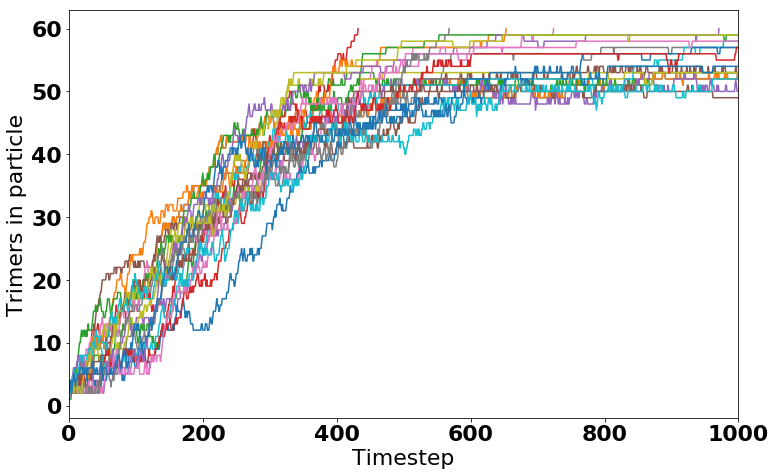

In [66]:
trimer_history = [timestep.trimer_number for timestep in particle.timesteps]
trimer_history = pd.Series(trimer_history,index=range(0,len(trimer_history)))
ax = history_series_list[0].plot()
ax.set_xlabel("Timestep")
ax.set_ylabel("Trimers in particle")
for history in history_series_list:
    history.plot(ax=ax)
ax.set_xlim(0,1000)

Text(0,0.5,'Trimers in particle')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


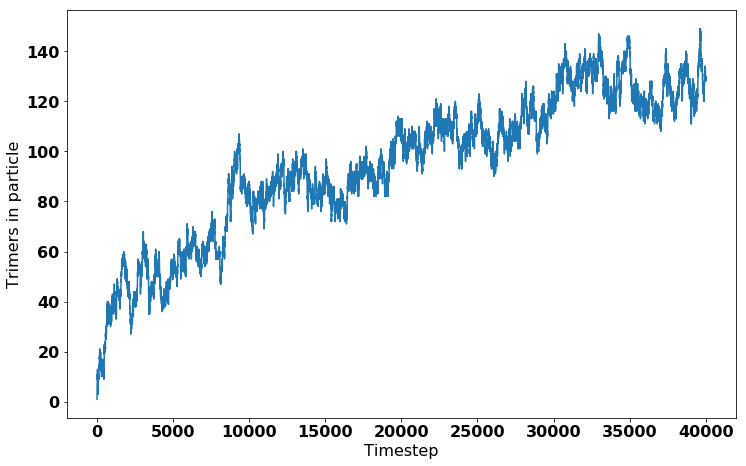

In [194]:
# plot trimer history
trimer_history = [timestep.trimer_number for timestep in particle.timesteps]
trimer_history = pd.Series(trimer_history,index=range(0,len(trimer_history)))
ax = trimer_history.plot()
ax.set_xlabel("Timestep")
ax.set_ylabel("Trimers in particle")


In [7]:
####### Rejections #######
add_outcomes = [timestep.add for timestep in particle.timesteps]
add_rejections = [outcome for outcome in add_outcomes if type(outcome) is Rejection]


Text(0.5,0,'Timestep')

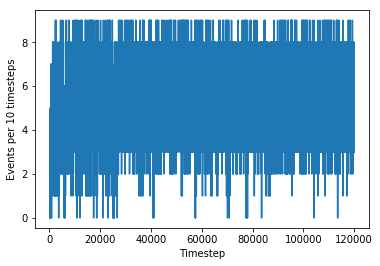

In [8]:
# rejection plotting
timesteps_of_interest= [timestep for timestep in particle.timesteps if (timestep.tried_to_add is True) and type(timestep.add) is Rejection]

bin_step = []
bins = []
binsize = 10
current_bin_max=timesteps_of_interest[0].step+binsize
count = 0
for timestep in  timesteps_of_interest:
    if timestep.step < current_bin_max:
        count+=1
    else:
        bins.append(count)
        bin_step.append(current_bin_max)
        current_bin_max+=binsize
        count = 0

remove_single_series = pd.Series(bins,index=bin_step)   
ax = remove_single_series.plot()
ax.set_ylabel("Events per "+str(binsize)+" timesteps")
ax.set_xlabel("Timestep")

Text(0.5,0,'Timestep')

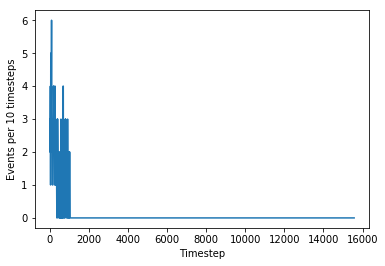

In [9]:
# removal plotting
timesteps_of_interest= [timestep for timestep in particle.timesteps if (timestep.tried_to_remove_single is True) and type(timestep.remove_single) is Acceptance]

bin_step = []
bins = []
binsize = 10
current_bin_max=timesteps_of_interest[0].step+binsize
count = 0
for timestep in  timesteps_of_interest:
    if timestep.step < current_bin_max:
        count+=1
    else:
        bins.append(count)
        bin_step.append(current_bin_max)
        current_bin_max+=binsize
        count = 0

remove_single_series = pd.Series(bins,index=bin_step)   
ax = remove_single_series.plot()
ax.set_ylabel("Events per "+str(binsize)+" timesteps")
ax.set_xlabel("Timestep")

Text(0.5,0,'Timestep')

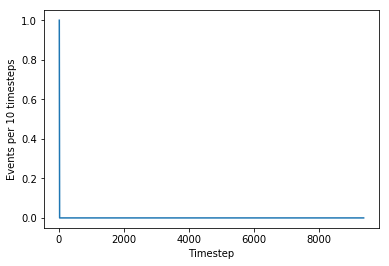

In [10]:
# plot removal of double bonded trimers
timesteps_of_interest= [timestep for timestep in particle.timesteps if (timestep.tried_to_remove_double is True) and type(timestep.remove_double) is Acceptance]

bin_step = []
bins = []
binsize = 10
current_bin_max=timesteps_of_interest[0].step+binsize
count = 0
for timestep in  timesteps_of_interest:
    if timestep.step < current_bin_max:
        count+=1
    else:
        bins.append(count)
        bin_step.append(current_bin_max)
        current_bin_max+=binsize
        count = 0

remove_double_series = pd.Series(bins,index=bin_step)   
ax = remove_double_series.plot()
ax.set_ylabel("Events per "+str(binsize)+" timesteps")
ax.set_xlabel("Timestep")

Text(0.5,0,'Timestep')

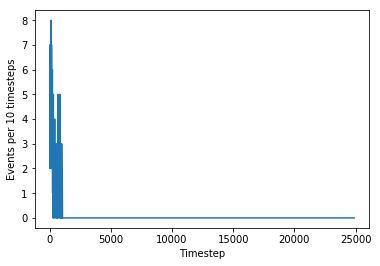

In [11]:
# plot the addition of subunits
timesteps_of_interest= [timestep for timestep in particle.timesteps if (timestep.tried_to_add is True) and type(timestep.add) is Acceptance]

bin_step = []
bins = []
binsize = 10
current_bin_max=timesteps_of_interest[0].step+binsize
count = 0
for timestep in  timesteps_of_interest:
    if timestep.step < current_bin_max:
        count+=1
    else:
        bins.append(count)
        bin_step.append(current_bin_max)
        current_bin_max+=binsize
        count = 0

add_series = pd.Series(bins,index=bin_step)   
ax = add_series.plot()
ax.set_ylabel("Events per "+str(binsize)+" timesteps")
ax.set_xlabel("Timestep")

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:1128: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5,0,'Timestep')

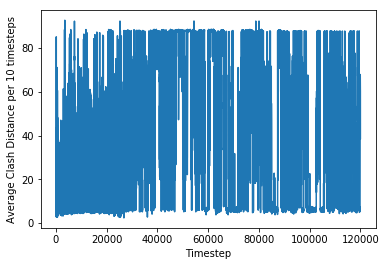

In [12]:
# clash distance
timesteps_of_interest= [timestep for timestep in particle.timesteps if (timestep.tried_to_add is True) and type(timestep.add) is Rejection]

bin_step = []
bins = []
binsize = 10
current_bin_max=timesteps_of_interest[0].step+binsize
count = []
for timestep in  timesteps_of_interest:
    if timestep.step < current_bin_max:
        count.append(timestep.add.clash_distance)
    else:
        bins.append(np.average(count))
        bin_step.append(current_bin_max)
        current_bin_max+=binsize
        count = []

add_series = pd.Series(bins,index=bin_step)   
ax = add_series.plot()
ax.set_ylabel("Average Clash Distance per "+str(binsize)+" timesteps")
ax.set_xlabel("Timestep")

In [16]:
particle.debug_verteces = set()
outcome = particle.add(trimer_type_request=7,debug=True)
print(type(outcome))
if type(outcome) is Rejection:
    print(outcome.rejection_type)

Trying to add trimer with template type: 7
<class 'Rejection.Rejection'>
1


In [17]:
dbgv = Vertex(outcome.clash_partner.coord)
particle.debug_verteces.add(dbgv)

In [20]:
outcome.clash_partner

In [18]:
particle.summarize()
outputdir = "output"
writer = Writer(outputdir,particle)
writer.write_particle()

Particle Summary:
	Current timestep:  5000
	Number of timestep objects:  5000
	Add attempts:  3353
	Add successes:  2519
	Remove single bonded attempts: 2642
	Remove single bonded successes:  2422
	Remove double bonded attempts: 44
	Remove double bonded successes:  44
	Trimers:  51
	Edges:  86
	Verteces:  36
	Debug Verteces:  4
	Open trimers:  13
	Open edges:  19
	Add Rejection histogram: 
		        778 : Add Error: vertex-vertex clash
		          0 : Add Error: top-vertex clash
		          0 : Add Error: top-top clash
		          0 : Add Error: tip-tip merge
		          0 : Add Error: unhandled number of hinge vertices
		          0 : Add Error: self clash
		          0 : Remove Error: number of open eges in trimer is not 1 or 2
		         55 : Add Error: Template generator error, probably too long of edge



Writing pdb file to: output/particle_99ae.pdb
Writing Chimera com file to: output/particle_99ae.com


In [19]:
from scipy.stats import boltzmann

In [29]:
import scipy.stats as stats    
alpha = 1
loc = 3
beta = 1.5
N = 10000
data = stats.gamma.rvs(alpha, loc=loc, scale=beta, size=N)  

In [30]:
s = pd.Series(data,index=range(0,N))

(0, 10)

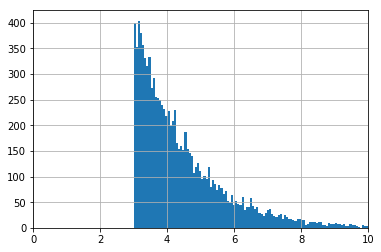

In [31]:
ax = s.hist(bins=200)
ax.set_xlim(0,10)

In [109]:
cut = [d for d in data if d>=12]

In [110]:
cut

[12.340599062060392,
 12.61686685157718,
 15.33047085656629,
 14.67655328474667,
 13.327871457448614,
 13.172608568339307,
 13.023974771991057,
 14.08985488814659,
 13.408364833953524,
 13.012770165192283,
 12.532978895152599,
 13.222917946181182,
 13.932155755995083,
 12.249290041475849,
 15.638290609459315,
 12.293390853466635,
 12.629972619642915,
 13.359487410796227,
 13.230401024881761,
 12.62509677675922,
 15.504349762520672,
 15.34405694937475,
 13.60207601743219]

(0, 10)

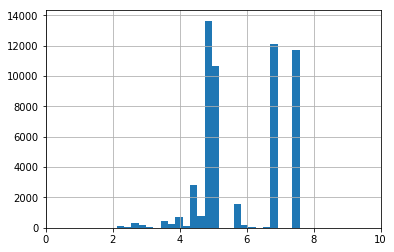

In [28]:
# plot rejection distance histogram
timesteps_of_interest= [timestep for timestep in particle.timesteps if (timestep.tried_to_add is True) and type(timestep.add) is Rejection]
distances = []
for timestep in timesteps_of_interest:
    rejection = timestep.add
    dist = rejection.clash_distance
    distances.append(dist)
distances = pd.Series(distances,index=range(0,len(distances)))
ax = distances.hist(bins=500)
ax.set_xlim(0,10)